# Import

In [79]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import GridSearchCV

# Day

### Load Dataset

In [80]:
# Load daily dataset
day_url = "https://raw.githubusercontent.com/michaeldavidsinn/csvml/refs/heads/main/day.csv"
day_df = pd.read_csv(day_url)

In [81]:
# Show dataset
day_df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


### Pre-Processing

In [82]:
# Show missing values
print(day_df.isnull().sum())

instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64


In [83]:
# Show info
day_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     731 non-null    int64  
 1   dteday      731 non-null    object 
 2   season      731 non-null    int64  
 3   yr          731 non-null    int64  
 4   mnth        731 non-null    int64  
 5   holiday     731 non-null    int64  
 6   weekday     731 non-null    int64  
 7   workingday  731 non-null    int64  
 8   weathersit  731 non-null    int64  
 9   temp        731 non-null    float64
 10  atemp       731 non-null    float64
 11  hum         731 non-null    float64
 12  windspeed   731 non-null    float64
 13  casual      731 non-null    int64  
 14  registered  731 non-null    int64  
 15  cnt         731 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.5+ KB


In [84]:
# Describe data
day_df.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,366.000000,2.496580,0.500684,6.519836,0.028728,2.997264,0.683995,1.395349,0.495385,0.474354,0.627894,0.190486,848.176471,3656.172367,4504.348837
std,211.165812,1.110807,0.500342,3.451913,0.167155,2.004787,0.465233,0.544894,0.183051,0.162961,0.142429,0.077498,686.622488,1560.256377,1937.211452
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.059130,0.079070,0.000000,0.022392,2.000000,20.000000,22.000000
25%,183.500000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,0.337083,0.337842,0.520000,0.134950,315.500000,2497.000000,3152.000000
50%,366.000000,3.000000,1.000000,7.000000,0.000000,3.000000,1.000000,1.000000,0.498333,0.486733,0.626667,0.180975,713.000000,3662.000000,4548.000000
75%,548.500000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,0.655417,0.608602,0.730209,0.233214,1096.000000,4776.500000,5956.000000
max,731.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,0.861667,0.840896,0.972500,0.507463,3410.000000,6946.000000,8714.000000


In [85]:
median_hum = day_df.loc[day_df['hum'] > 0, 'hum'].median()
day_df['hum'] = day_df['hum'].replace(0, median_hum)

In [86]:
# Convert 'dteday' to datetime format and set index
day_df['dteday'] = pd.to_datetime(day_df['dteday'])
day_df.set_index('dteday', inplace=True)

In [87]:
# Selected features for daily modeling
selected_features = ['temp', 'hum', 'windspeed', 'season', 'weathersit', 'yr', 'mnth', 'holiday', 'weekday', 'workingday']

In [88]:
# Scale the features for XGBoost (daily data)
scaler = StandardScaler()
day_df[selected_features] = scaler.fit_transform(day_df[selected_features])

In [89]:
# Split day data into train and test sets
X_day = day_df[selected_features]
y_day = day_df['cnt']

X_train_day, X_test_day, y_train_day, y_test_day = train_test_split(X_day, y_day, test_size=0.2)

### Visualization

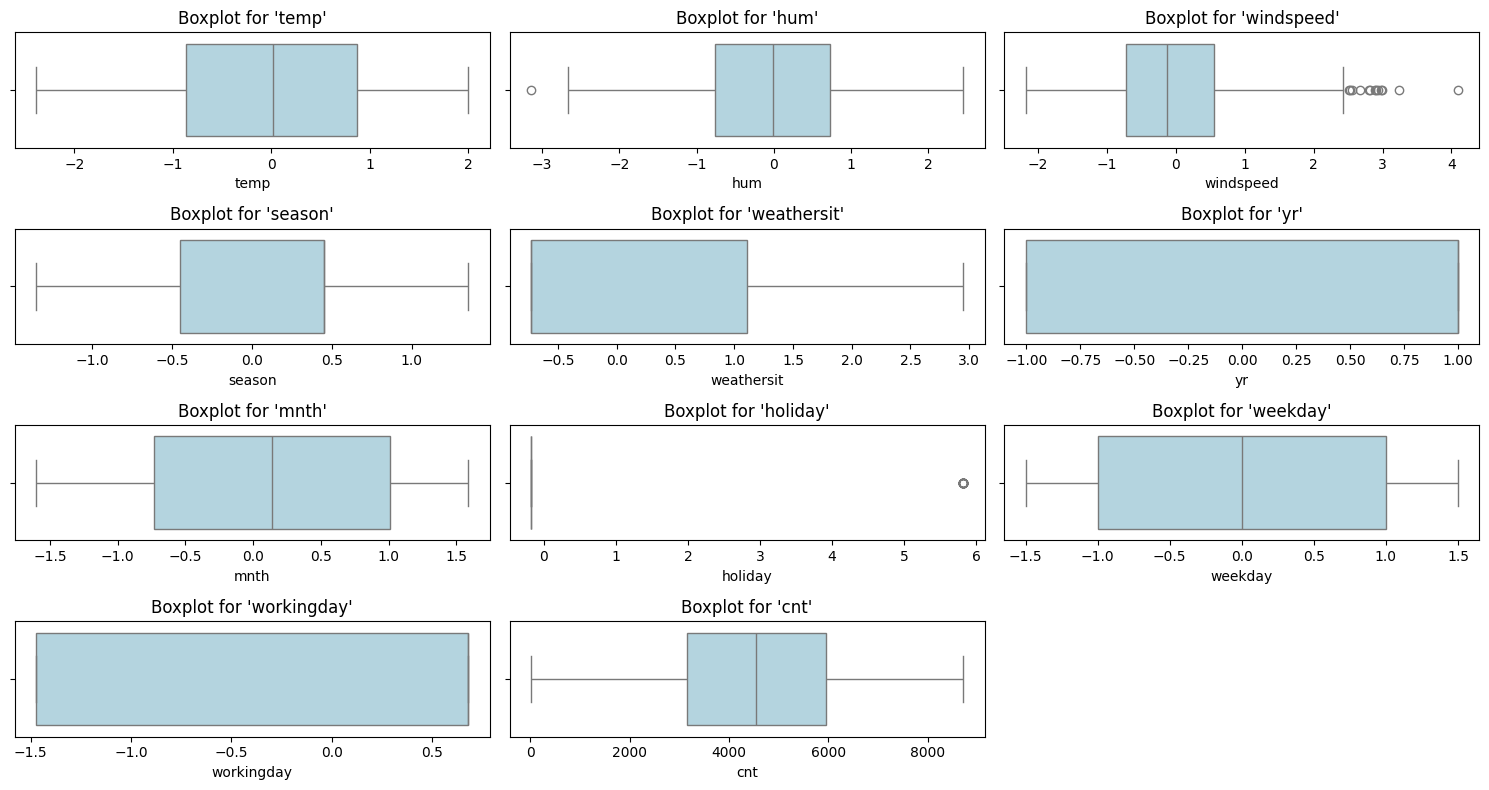

In [114]:
import seaborn as sns
import matplotlib.pyplot as plt

# Function to identify outliers using IQR for all numerical columns
def detect_outliers(day_df, column):
    # Calculate the Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = day_df[column].quantile(0.25)
    Q3 = day_df[column].quantile(0.75)
    
    # Calculate the IQR (Interquartile Range)
    IQR = Q3 - Q1
    
    # Determine the lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identify the outliers
    outliers = day_df[(day_df[column] < lower_bound) | (day_df[column] > upper_bound)]
    
    return outliers

# Number of rows and columns for the subplots
n_cols = 3  # Number of columns per row
n_rows = (len(selected_features) + n_cols - 1) // n_cols  # Calculate the number of rows required

# Create a figure with multiple subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 2 * n_rows))

# Flatten axes array for easy indexing
axes = axes.flatten()

# Loop through columns and create boxplots in subplots
for i, column in enumerate(selected_features):
    # Plot boxplot for the column
    sns.boxplot(x=day_df[column], color='lightblue', ax=axes[i])
    axes[i].set_title(f"Boxplot for '{column}'")
    axes[i].set_xlabel(column)

# Remove any extra subplots if there are fewer columns than subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()


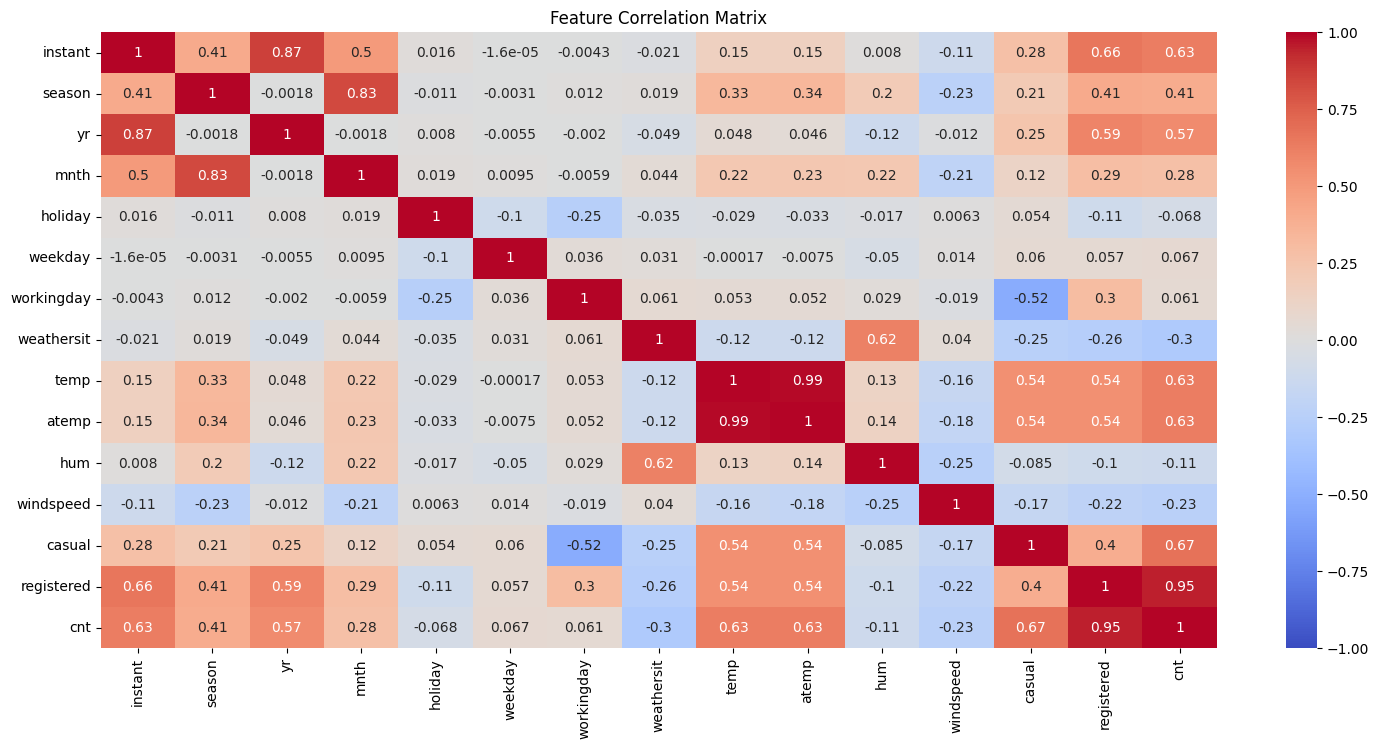

In [91]:
# Visualize using Correlation Matrix
correlation_matrix = day_df.corr()

plt.figure(figsize=(18, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Feature Correlation Matrix')
plt.show()

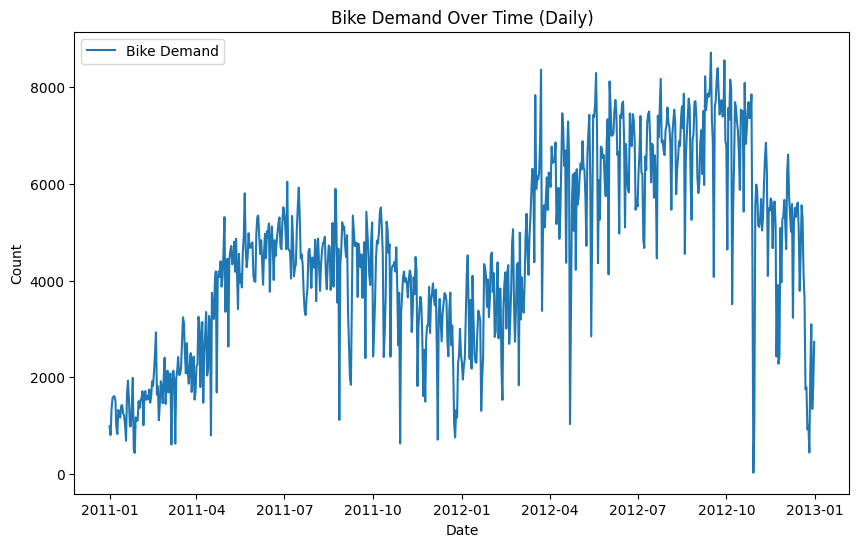

In [92]:
# Visualize the bike demand data (daily)
plt.figure(figsize=(10, 6))
plt.plot(day_df['cnt'], label="Bike Demand")
plt.title("Bike Demand Over Time (Daily)")
plt.xlabel("Date")
plt.ylabel("Count")
plt.legend()
plt.show()

### Processing

In [93]:
# SARIMAX model fitting (daily)
sarimax_model = SARIMAX(day_df['cnt'],
                        exog=day_df[selected_features],
                        order=(1, 1, 1),
                        seasonal_order=(1, 1, 1, 12),  # Monthly seasonality
                        enforce_stationarity=False,
                        enforce_invertibility=False)
results = sarimax_model.fit()

sarimax_predictions = results.predict(start=day_df.index[0], end=day_df.index[-1], exog=day_df[selected_features])
residuals = day_df['cnt'] - sarimax_predictions


/Users/mds/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/mds/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.91388D+00    |proj g|=  1.13055D-01

At iterate    5    f=  7.86856D+00    |proj g|=  1.26863D-01

At iterate   10    f=  7.86668D+00    |proj g|=  2.02143D-03

At iterate   15    f=  7.86666D+00    |proj g|=  1.73838D-03

At iterate   20    f=  7.86555D+00    |proj g|=  2.48560D-02

At iterate   25    f=  7.82001D+00    |proj g|=  1.36225D-01

At iterate   30    f=  7.75411D+00    |proj g|=  4.99794D-02

At iterate   35    f=  7.75123D+00    |proj g|=  2.02150D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

In [94]:
X_train_residuals = X_train_day
y_train_residuals = residuals.loc[X_train_day.index]

In [95]:
# Hyperparameter tuning for XGBoost
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}
xgb_model = XGBRegressor(random_state=42)

In [96]:
# Perform GridSearch 
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train_residuals, y_train_residuals)
best_xgb_model = grid_search.best_estimator_
print(f"Best XGBoost Parameters (Daily): {grid_search.best_params_}")

Best XGBoost Parameters (Daily): {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100}


In [97]:
# Predict residuals using tuned XGBoost model (daily)
xgb_residual_predictions = best_xgb_model.predict(X_train_residuals)

In [98]:
day_df[selected_features]

,temp,hum,windspeed,season,weathersit,yr,mnth,holiday,weekday,workingday
dteday,,,,,,,,,,
2011-01-01,-0.826662,1.261067,-0.387892,-1.348213,1.110427,-1.001369,-1.600161,-0.171981,1.498809,-1.471225
2011-01-02,-0.721095,0.479521,0.749602,-1.348213,1.110427,-1.001369,-1.600161,-0.171981,-1.496077,-1.471225
2011-01-03,-1.634657,-1.363600,0.746632,-1.348213,-0.726048,-1.001369,-1.600161,-0.171981,-0.996930,0.679706
2011-01-04,-1.614780,-0.272870,-0.389829,-1.348213,-0.726048,-1.001369,-1.600161,-0.171981,-0.497782,0.679706
2011-01-05,-1.467414,-1.365850,-0.046307,-1.348213,-0.726048,-1.001369,-1.600161,-0.171981,0.001366,0.679706
...,...,...,...,...,...,...,...,...,...,...
2012-12-27,-1.318665,0.172090,2.061426,-1.348213,1.110427,0.998633,1.588660,-0.171981,0.500513,0.679706
2012-12-28,-1.323224,-0.275968,-0.452131,-1.348213,1.110427,0.998633,1.588660,-0.171981,0.999661,0.679706
2012-12-29,-1.323224,0.884231,-0.853552,-1.348213,1.110427,0.998633,1.588660,-0.171981,1.498809,-1.471225


### Evaluation

In [99]:
# Predict using SARIMAX and XGBoost for the entire dataset (daily)
sarimax_predictions_full = results.predict(start=day_df.index[0], end=day_df.index[-1], exog=day_df[selected_features])
xgb_residual_predictions_full = best_xgb_model.predict(day_df[selected_features])

In [100]:
# Combine SARIMAX and XGBoost predictions (daily)
final_predictions = sarimax_predictions_full + xgb_residual_predictions_full

In [101]:
final_predictions

2011-01-01    3478.077874
2011-01-02     391.864884
2011-01-03     979.154727
2011-01-04    1312.136904
2011-01-05    1998.872627
                 ...     
2012-12-27    1985.301191
2012-12-28    3015.491493
2012-12-29    2647.933752
2012-12-30    1883.477723
2012-12-31    2077.240363
Freq: D, Name: predicted_mean, Length: 731, dtype: float64

In [102]:
# Evaluate combined model (daily)
mae_combined = mean_absolute_error(day_df['cnt'], final_predictions)
mse_combined = mean_squared_error(day_df['cnt'], final_predictions)
r2_combined = r2_score(day_df['cnt'], final_predictions)
print(f"Combined Model MAE (Daily): {mae_combined:.2f}")
print(f"Combined Model MSE (Daily): {mse_combined:.2f}")
print(f"Combined Model R2 (Daily): {r2_combined:.2f}")

Combined Model MAE (Daily): 472.77
Combined Model MSE (Daily): 431541.39
Combined Model R2 (Daily): 0.88


### Model Result

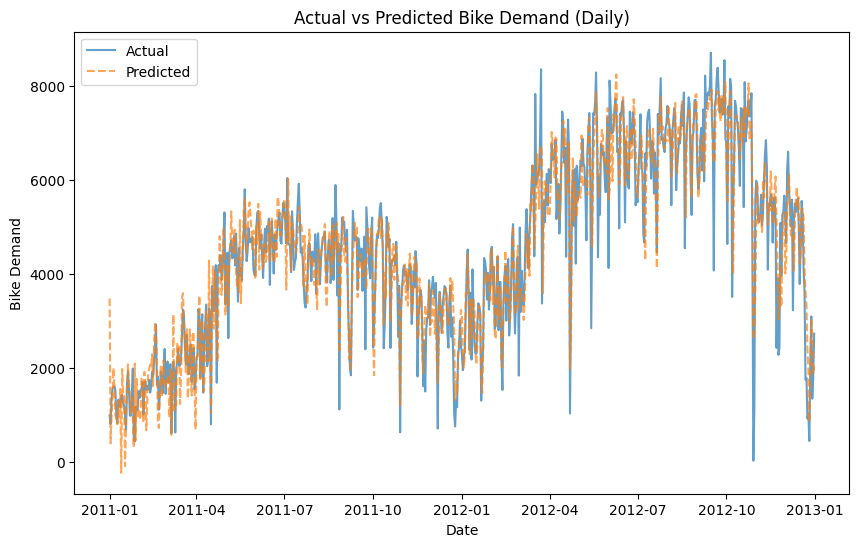

In [103]:
# Visualize actual vs predicted values (daily)
plt.figure(figsize=(10, 6))
plt.plot(day_df['cnt'], label="Actual", alpha=0.7)
plt.plot(final_predictions, label="Predicted", linestyle='--', alpha=0.7)
plt.title("Actual vs Predicted Bike Demand (Daily)")
plt.xlabel("Date")
plt.ylabel("Bike Demand")
plt.legend()
plt.show()

In [104]:
X_train_day, X_test_day, y_train_day, y_test_day = train_test_split(X_day, y_day, test_size=0.2, shuffle=False)

/Users/mds/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/mds/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/mds/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Absolute Error: 952.2555390439126


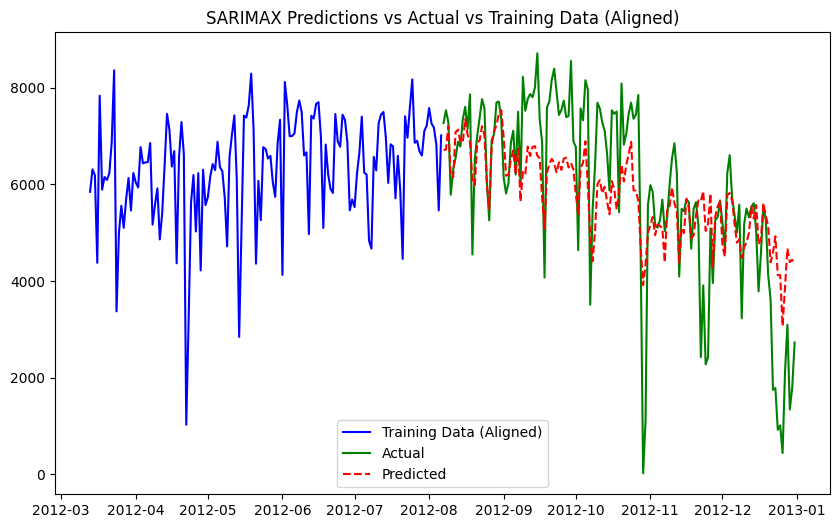

In [105]:

import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
# Define the SARIMAX model with the features from X_train_day and the target variable y_train_day
sarimax_model = sm.tsa.SARIMAX(y_train_day,
                               exog=X_train_day,
                               order=(1, 1, 1),        # ARIMA order
                               seasonal_order=(1, 1, 1, 7),  # Seasonal order (7 is just an example for weekly seasonality)
                               enforce_stationarity=False,
                               enforce_invertibility=False)

# Fit the model
sarimax_fitted = sarimax_model.fit(disp=False)

# Make predictions on the test data
y_pred_day = sarimax_fitted.predict(start=X_test_day.index[0], end=X_test_day.index[-1], exog=X_test_day)

# Evaluate the model using Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_day, y_pred_day)
print(f"Mean Absolute Error: {mae}")

# Visualize the training data from the point where the test data starts
start_idx = len(y_train_day) - len(y_test_day)  # Start index for training data

# Plot only the second half of the training data
half_train_data = y_train_day[start_idx:]  # Get the portion of the training data that aligns with the test data

plt.figure(figsize=(10, 6))
plt.plot(half_train_data, label='Training Data (Aligned)', color='blue')  # Plot the aligned training data
plt.plot(y_test_day, label='Actual', color='green')         # Plot actual test data
plt.plot(y_pred_day, label='Predicted', linestyle='--', color='red')  # Plot predicted values
plt.legend()
plt.title('SARIMAX Predictions vs Actual vs Training Data (Aligned)')
plt.show()